In [1]:
import numpy as np
import pandas as pd
import healpy as hp
%config InlineBackend.figure_format = 'retina'
from DS_Planck_Unet import west_val, east_val
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask, draw_pic, val_pix
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits, normalize
from DS_detector import *
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_data_transformation import normalize
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from scipy.special import logit
from DS_models_stat import stat_orig_cats
from DS_detector import rematch_cat
from matplotlib import cm
from matplotlib.ticker import LinearLocator


In [30]:
all_model = load_planck_model('/home/rt2122/Models/pz_only_rot/pz_only_rot.ep0028-vl0.005815-l0.004588.hdf5')

In [2]:
true_clusters = pd.concat([pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv'), 
                           pd.read_csv('/home/rt2122/Data/clusters/acts/all_found.csv')])
true_clusters['pix2'] = radec2pix(true_clusters['RA'], true_clusters['DEC'], 2)


In [3]:
fav_clusters = pd.DataFrame([
    {'RA' : 176.1500, 'DEC' : 19.7589, 'name' : 'Leo'},
    {'RA' : 194.9542, 'DEC': 27.9806, 'name' : 'Coma'},
    {'RA' : 44.2583, 'DEC' : 13.0049, 'name' : 'A399-A401'},
    {'RA' : 201.9792, 'DEC' : -31.2333, 'name' : 'Shapley'}, 
    {'RA' : 150.507, 'DEC' : +2.31204, 'name' : 'G237.0+42.5'}
])
fav_clusters['pix2'] = radec2pix(fav_clusters['RA'], fav_clusters['DEC'], 2)
fav_clusters['pix'] = radec2pix(fav_clusters['RA'], fav_clusters['DEC'], 2**11)
fav_clusters

,RA,DEC,name,pix2,pix
0,176.1500,19.75890,Leo,11,12344968
1,194.9542,27.98060,Coma,3,4191272
2,44.2583,13.00490,A399-A401,37,39244338
3,201.9792,-31.23330,Shapley,12,13529997
4,150.5070,2.31204,G237.0+42.5,9,10158405


In [31]:
for pix2 in tqdm(fav_clusters['pix2']):
    all_data_dict = gen_pics_for_detection(pix2, all_model, step=4, only=True, data_type=np.float)
    all_connected = connect_masks(all_data_dict['ans'], all_data_dict['pic_idx'], data_type=np.float16)
    np.save('/home/rt2122/Data/cur/favourite_clusters/pz_rot/{pix2}.npy'.format(pix2=pix2), all_connected)
    del all_data_dict

In [4]:
def cut_in_rad(df, center, radius):
    cen_sc = SkyCoord(ra=center[0]*u.degree, dec=center[1]*u.degree, frame='icrs')
    sc = SkyCoord(ra=np.array(df['RA'])*u.degree, dec=np.array(df['DEC'])*u.degree, frame='icrs')
    df = df[sc.separation(cen_sc).degree <= radius]
    df.index = np.arange(len(df))
    return df

def pix2sc(pix, nside):
    ra, dec = pix2radec(pix, nside=nside)
    sc = SkyCoord(ra=np.array(ra)*u.degree, 
                  dec=np.array(dec)*u.degree, frame='icrs')
    return sc

def find_rad_by_matr(matr):
    dist1 = pix2sc(matr[0,0], 2**11).separation(pix2sc(matr[-1,-1], 2**11)).degree
    dist2 = pix2sc(matr[0,-1], 2**11).separation(pix2sc(matr[-1,0], 2**11)).degree
    return max(dist1/2, dist2/2)


def calc_coords(this_df, sm_mdict):
    this_df['x'] = -1
    this_df['y'] = -1
    this_df['pix'] = radec2pix(this_df['RA'], this_df['DEC'], 2**11)
    for i in range(len(this_df)):
        p = this_df.loc[i, 'pix']
        if p in sm_mdict:
            x, y = sm_mdict[p]
            this_df.loc[i, 'x'] = x
            this_df.loc[i, 'y'] = y
    return this_df

In [32]:
def pic9(i, size=32, marker_size=100, add_markers=True, picshape=np.array([5, 5]), dir_name='all_found',
        found_cat_name='/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv',
        print_gt_clusters=False, model_name='Best model', eps=1e-6): 
    
    
    line = fav_clusters.iloc[i]
    pix2 = line['pix2']
    print(line)
    
    matr = one_pixel_fragmentation(2, pix2, 10)
    mdict = matr2dict(matr)
    all_connected = np.load('/home/rt2122/Data/cur/favourite_clusters/{dir_name}/{pix2}.npy'.format(pix2=pix2, dir_name=dir_name))
    
    x_cl, y_cl = mdict[line['pix']]
    sm_matr = matr[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    rad_check = find_rad_by_matr(sm_matr)
    
    cur_true = cut_in_rad(true_clusters.copy(), [line['RA'], line['DEC']], rad_check)
    cur_found = cut_in_rad(pd.read_csv(found_cat_name), [line['RA'], line['DEC']], rad_check)
    if print_gt_clusters:
        print(cur_true)
    
    coords = np.stack([cur_true['RA'], cur_true['DEC']]).T
    pic, mask = draw_pic_with_mask(None, coords, matr=matr)
    ypic = draw_pic(matr, y=True)
    
    sm_pic = pic[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_ypic = ypic[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_mask = mask[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_mdict = matr2dict(sm_matr)
    sm_all = all_connected[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    
    
    cur_true = calc_coords(cur_true, sm_mdict)
    cur_found = calc_coords(cur_found, sm_mdict)
    
    
    _, ax = plt.subplots(3, 3, figsize=3 * picshape, sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.001)
    
    pic_dict = {6 : logit(sm_all + eps), 7 : sm_ypic, 8:sm_mask}
    
    for i in range(3):
        for j in range(3):
            if 3*i+j < 6:
                ax[i][j].imshow(sm_pic[:,:,3*i+j])
                ax[i][j].set_xlabel(3*i+j)
            else:
                ax[i][j].imshow(pic_dict[3*i+j][:,:,0])
    if add_markers:
        for i in range(3):
            for j in range(3):
                s_obj = ax[i][j].scatter(cur_true[cur_true['y'] >= 0]['y'], cur_true[cur_true['y'] >= 0]['x'], marker='x', c='r', 
                                         s=marker_size, alpha=0.8)
                if i == 2 and j == 2:
                    s_obj.set_label('gt')
                s_obj = ax[i][j].scatter(cur_found[cur_found['y'] >= 0]['y'], cur_found[cur_found['y'] >= 0]['x'], marker='+', 
                                         c='orange', s=marker_size, alpha=0.8)
                if i == 2 and j == 2:
                    s_obj.set_label('detected')
                    ax[i][j].legend()
            
    ax[2][1].set_xlabel('y map')
    ax[2][0].set_xlabel(model_name+' prediction')
    ax[2][2].set_xlabel(line['name'])
    return logit(sm_all + eps), sm_ypic

In [33]:
pics_dict = {}

RA        176.15
DEC      19.7589
name         Leo
pix2          11
pix     12344968
Name: 0, dtype: object


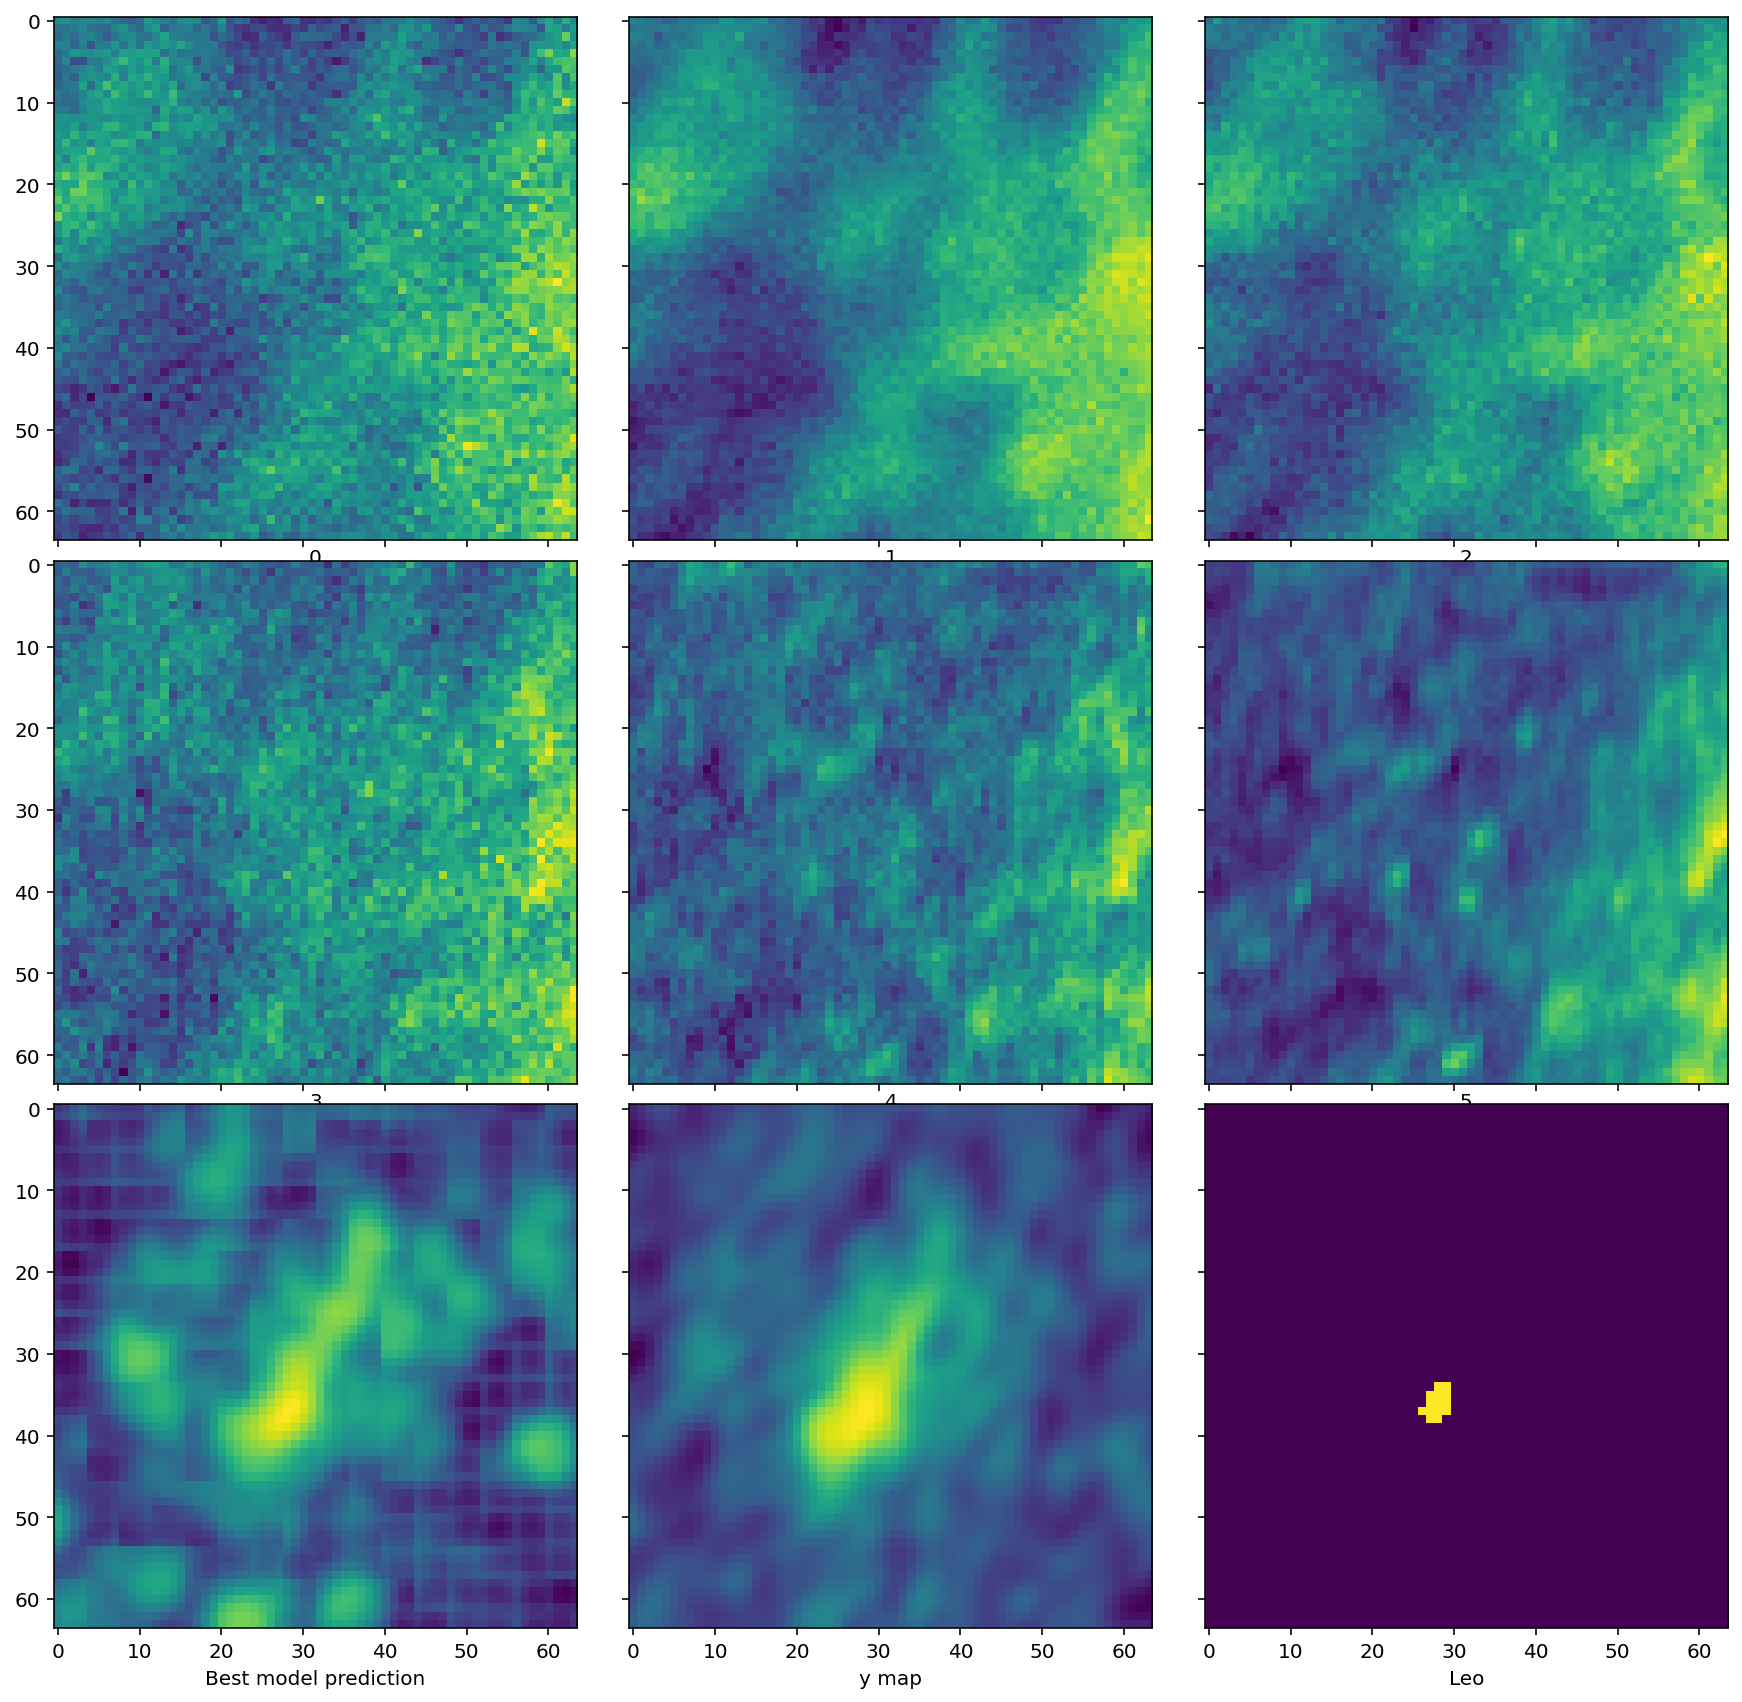

In [53]:
pics_dict['Leo'] = pic9(0, size=32, add_markers=False) 
                        #dir_name='pz_rot', model_name='pz_rot', 
                         #found_cat_name='/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8_no_fn.csv')

RA      194.954
DEC     27.9806
name       Coma
pix2          3
pix     4191272
Name: 1, dtype: object


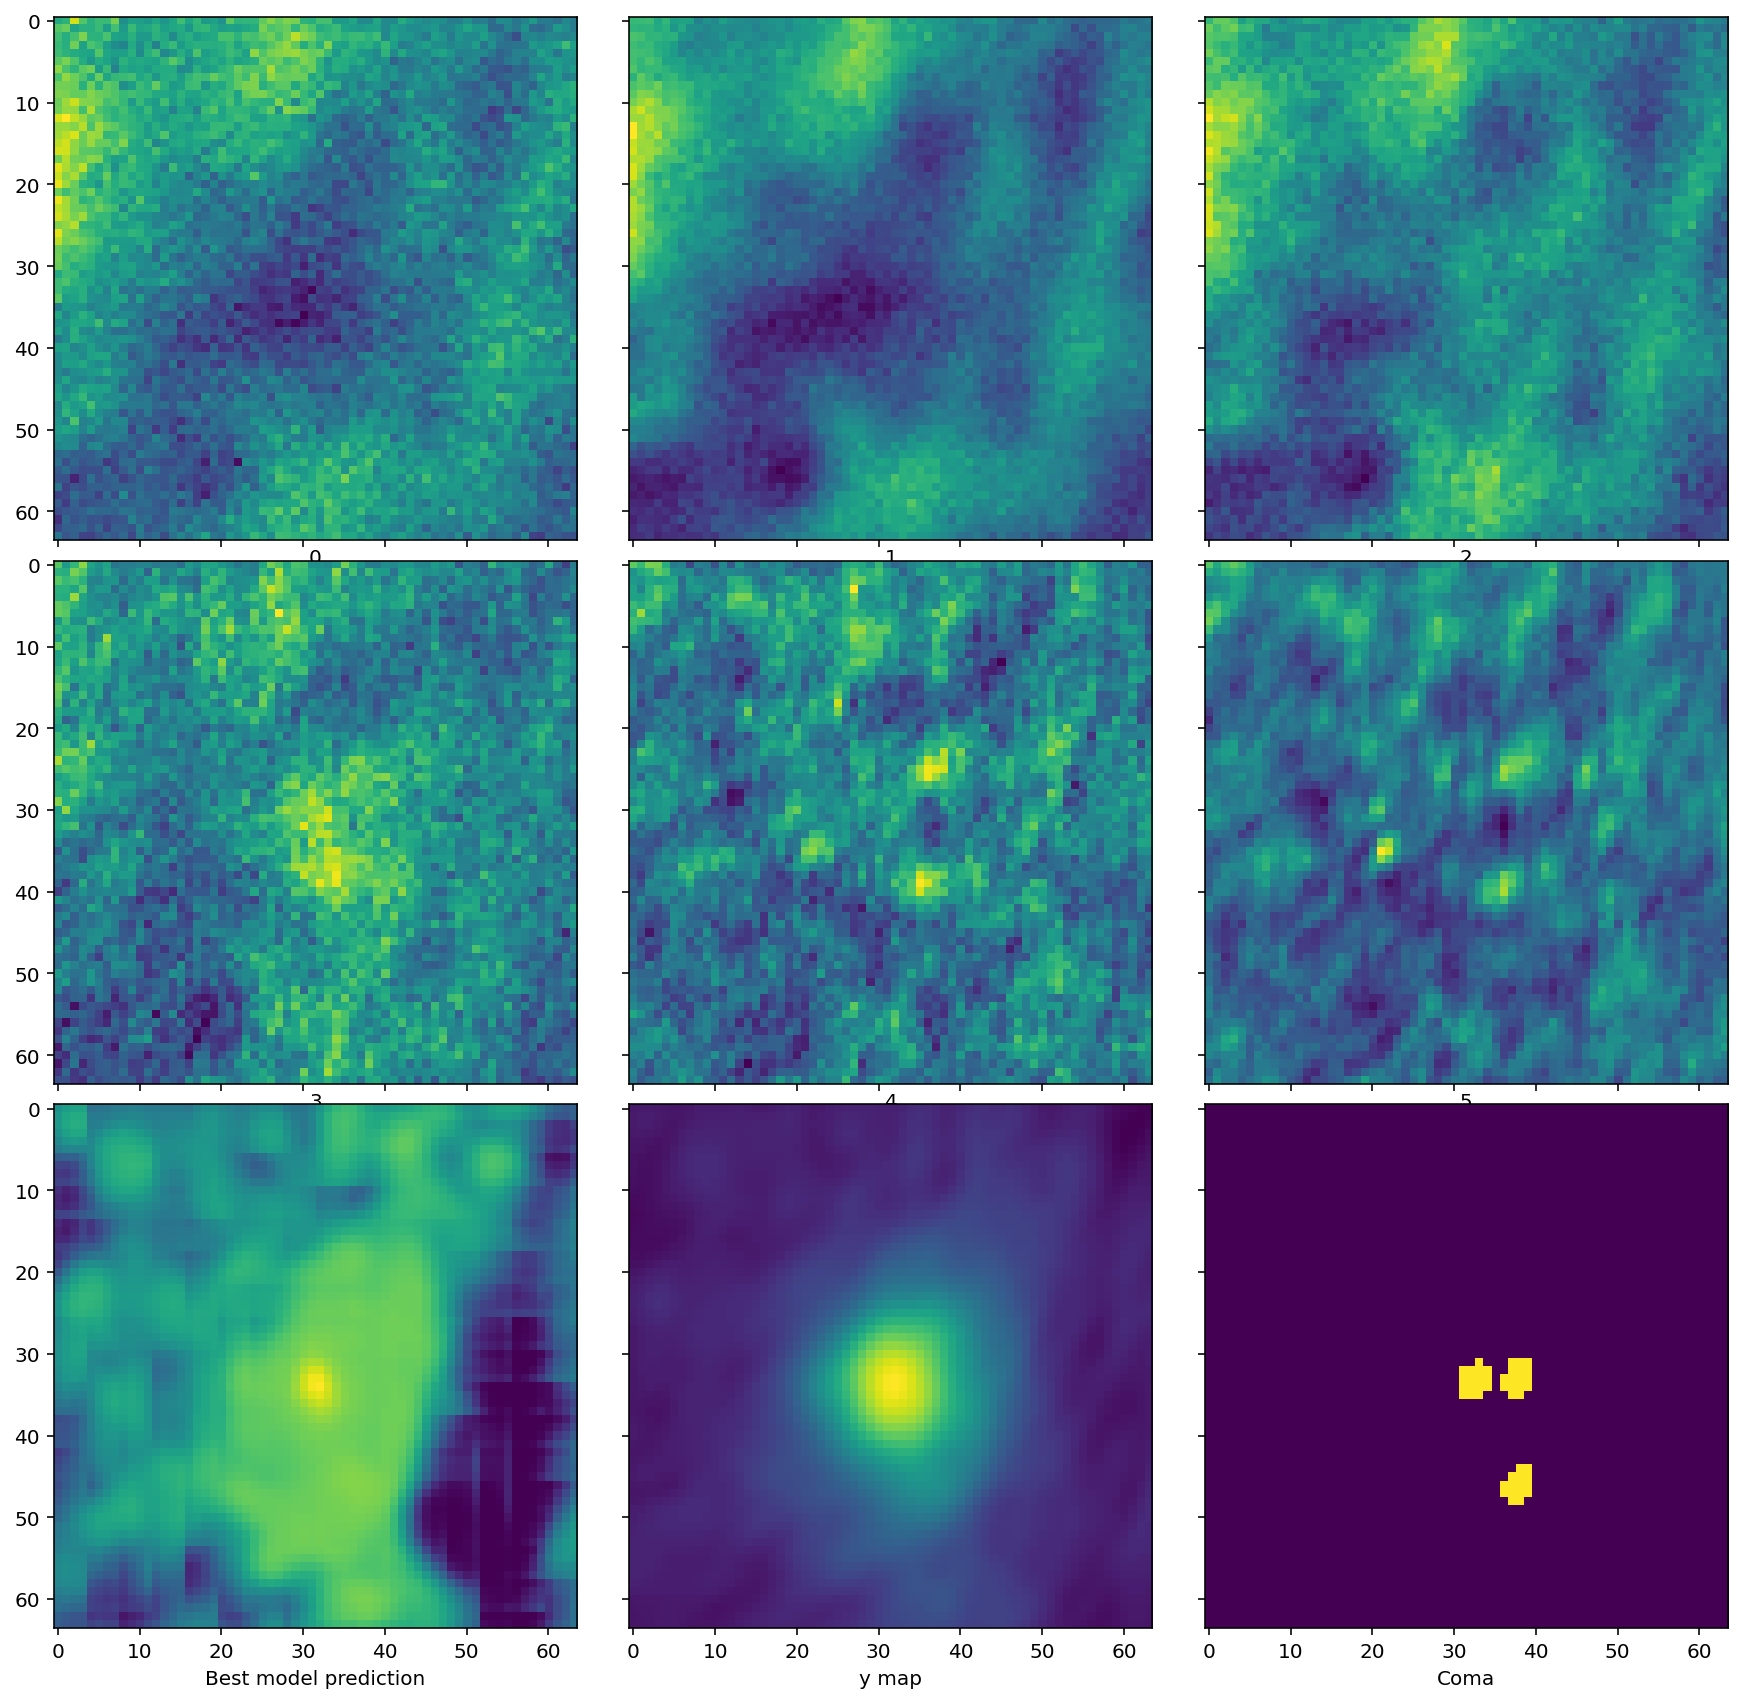

In [54]:
pics_dict['Coma'] = pic9(1, add_markers=False, size=32)
                         #, picshape=np.array([5, 6.5]), print_gt_clusters=True)
     #dir_name='pz_rot', model_name='pz_rot', 
     #found_cat_name='/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8_no_fn.csv')

RA        44.2583
DEC       13.0049
name    A399-A401
pix2           37
pix      39244338
Name: 2, dtype: object


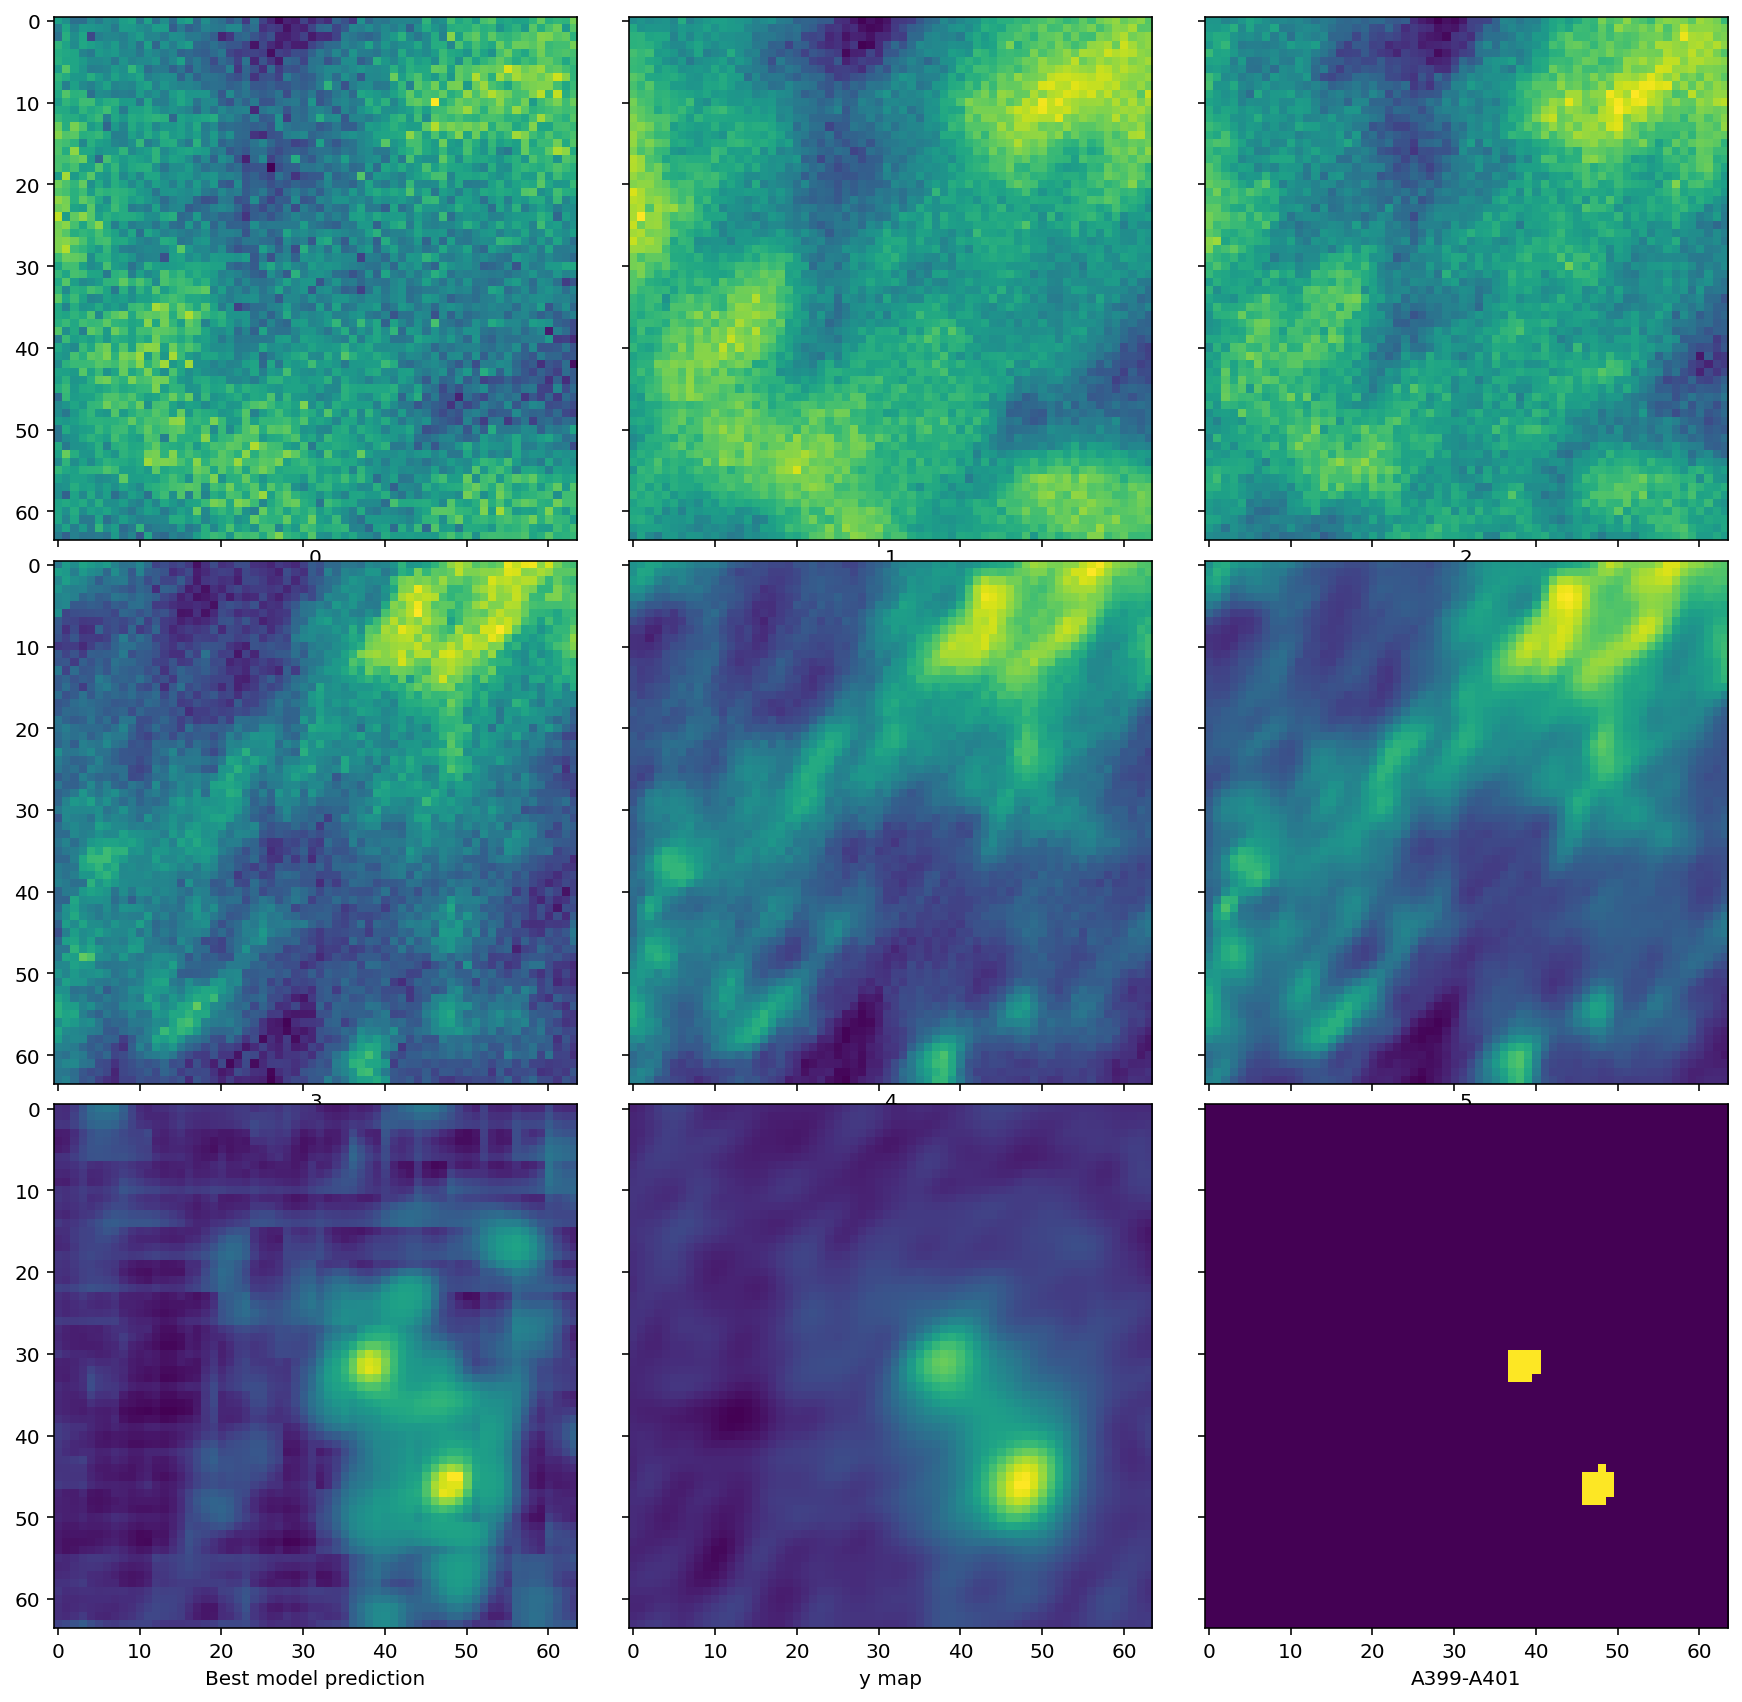

In [55]:
pics_dict['A399-A401'] = pic9(2, add_markers=False, size=32) 
                 #dir_name='pz_rot', model_name='pz_rot', 
     #found_cat_name='/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8_no_fn.csv')

RA       201.979
DEC     -31.2333
name     Shapley
pix2          12
pix     13529997
Name: 3, dtype: object


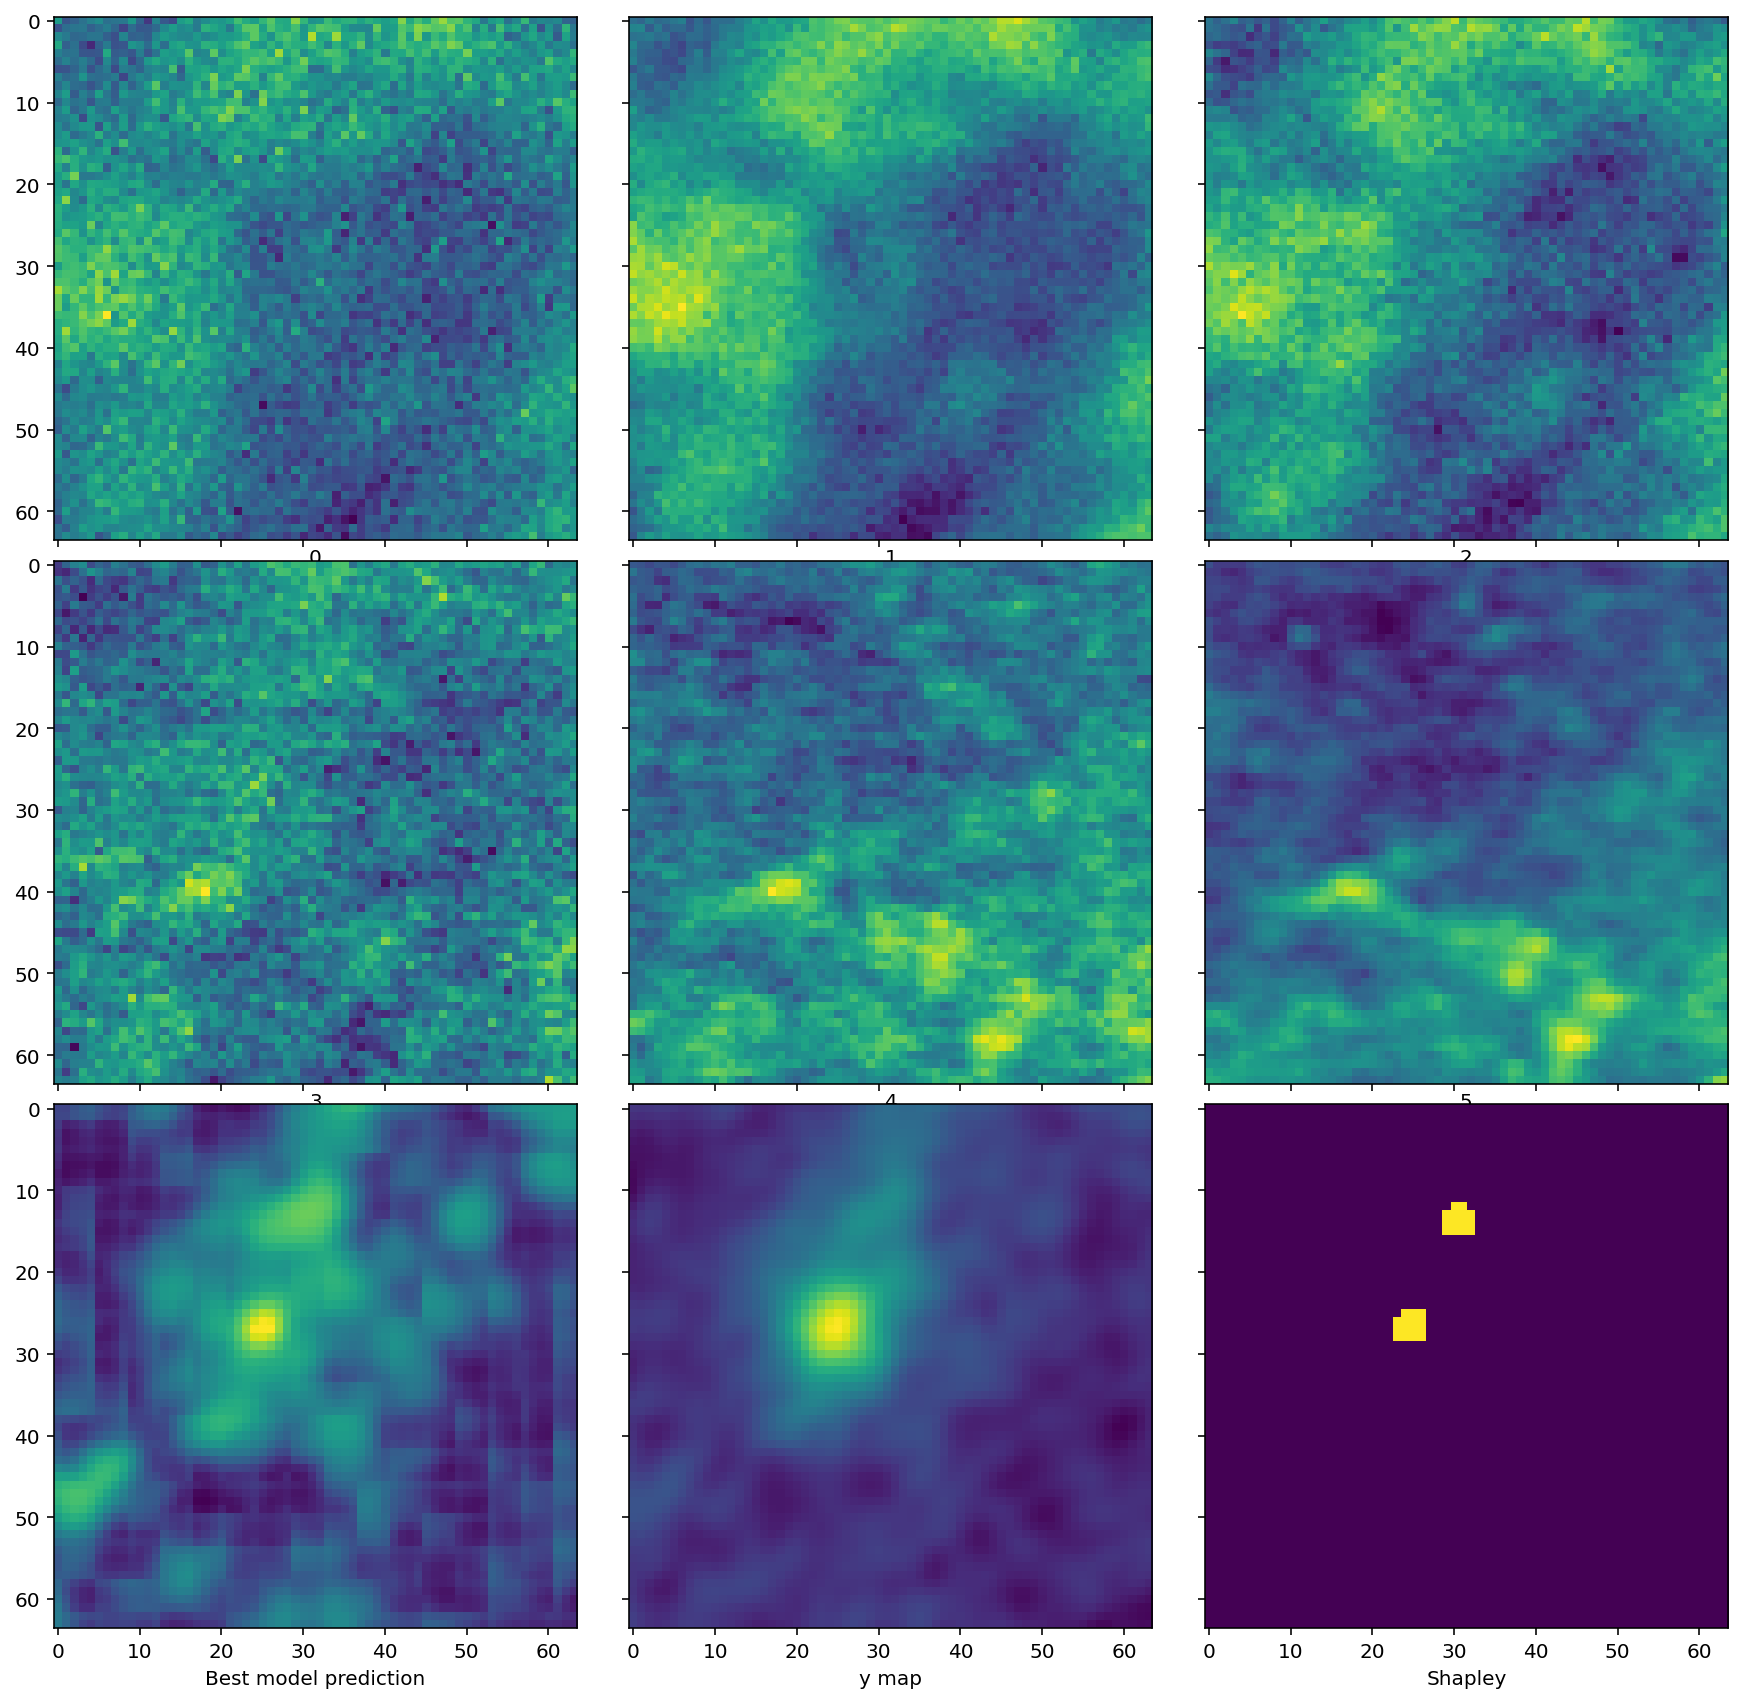

In [56]:
pics_dict['Shapley'] = pic9(3, 32, add_markers=False) 
                            #dir_name='pz_rot', model_name='pz_rot', 
     #found_cat_name='/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8_no_fn.csv')

RA          150.507
DEC         2.31204
name    G237.0+42.5
pix2              9
pix        10158405
Name: 4, dtype: object


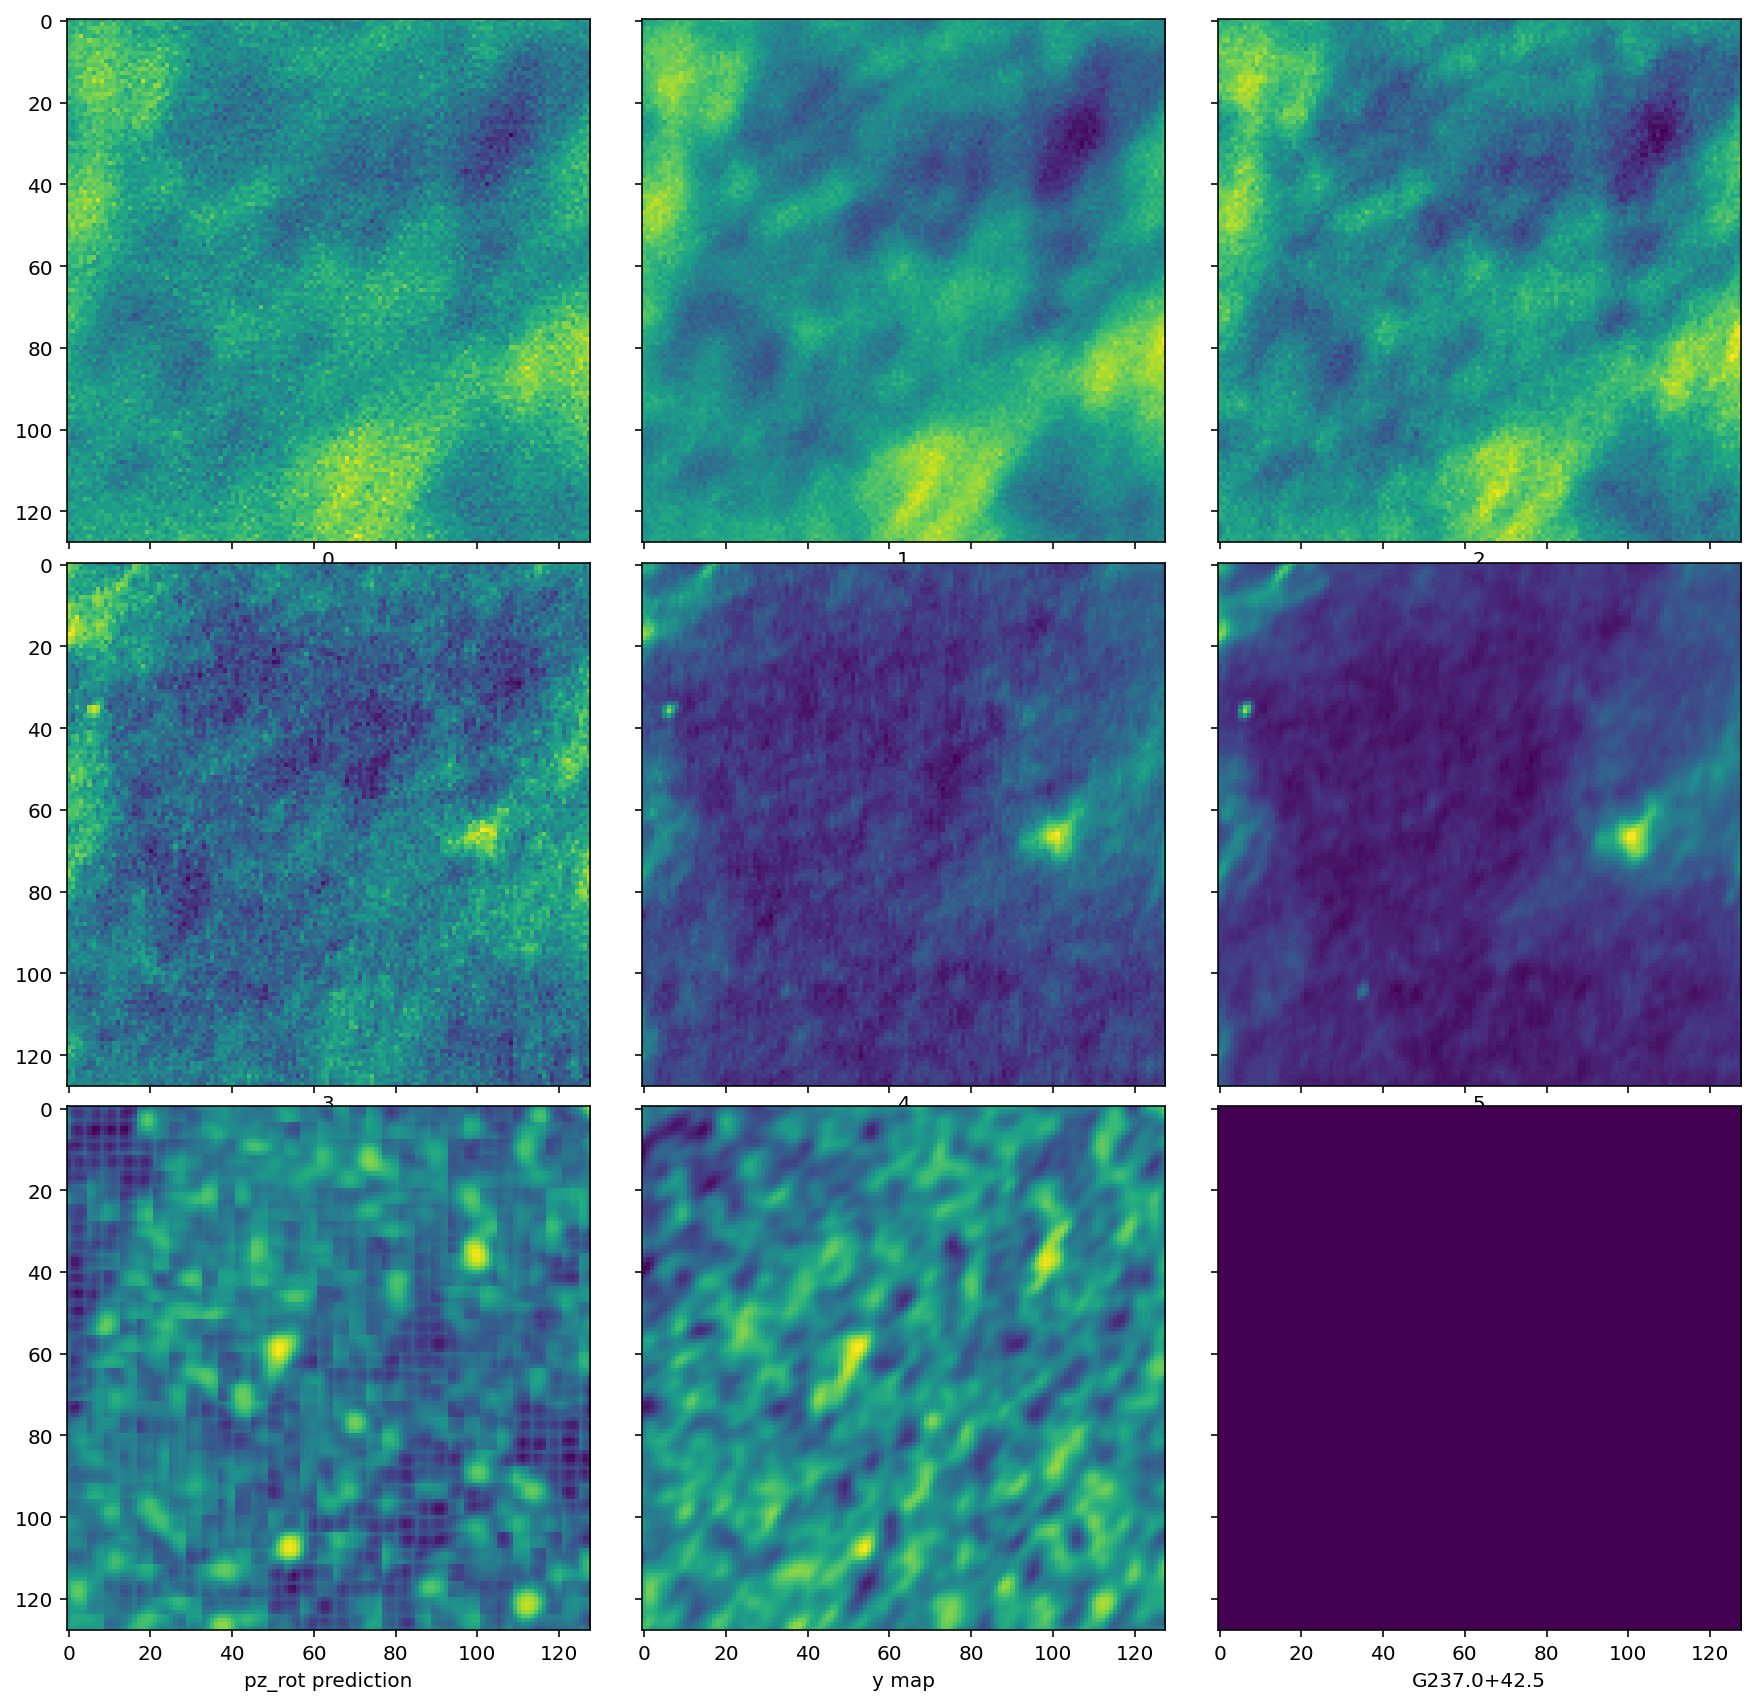

In [78]:
pic9(4, 64, add_markers=False, dir_name='pz_rot', model_name='pz_rot', 
     found_cat_name='/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8_no_fn.csv')

In [25]:
a = logit(np.load('/home/rt2122/Data/cur/favourite_clusters/pz_rot/11.npy'))

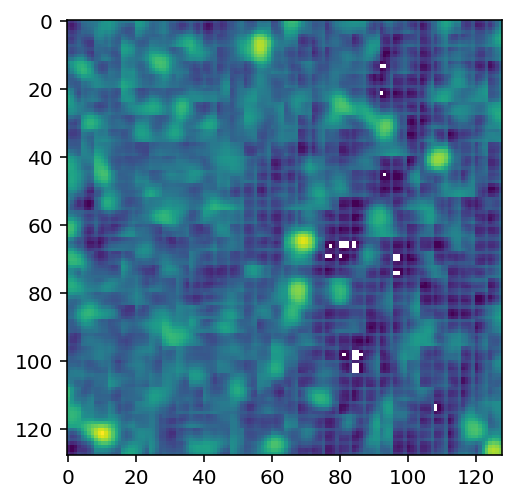

In [26]:
x=2
y=7
plt.imshow(a[x*128:(x+1)*128,y*128:(y+1)*128,0].astype(np.float32))

In [27]:
a.min(), a.max(), np.isnan(a).any()

(-inf, 7.6241307, False)

In [28]:
logit(0)

-inf

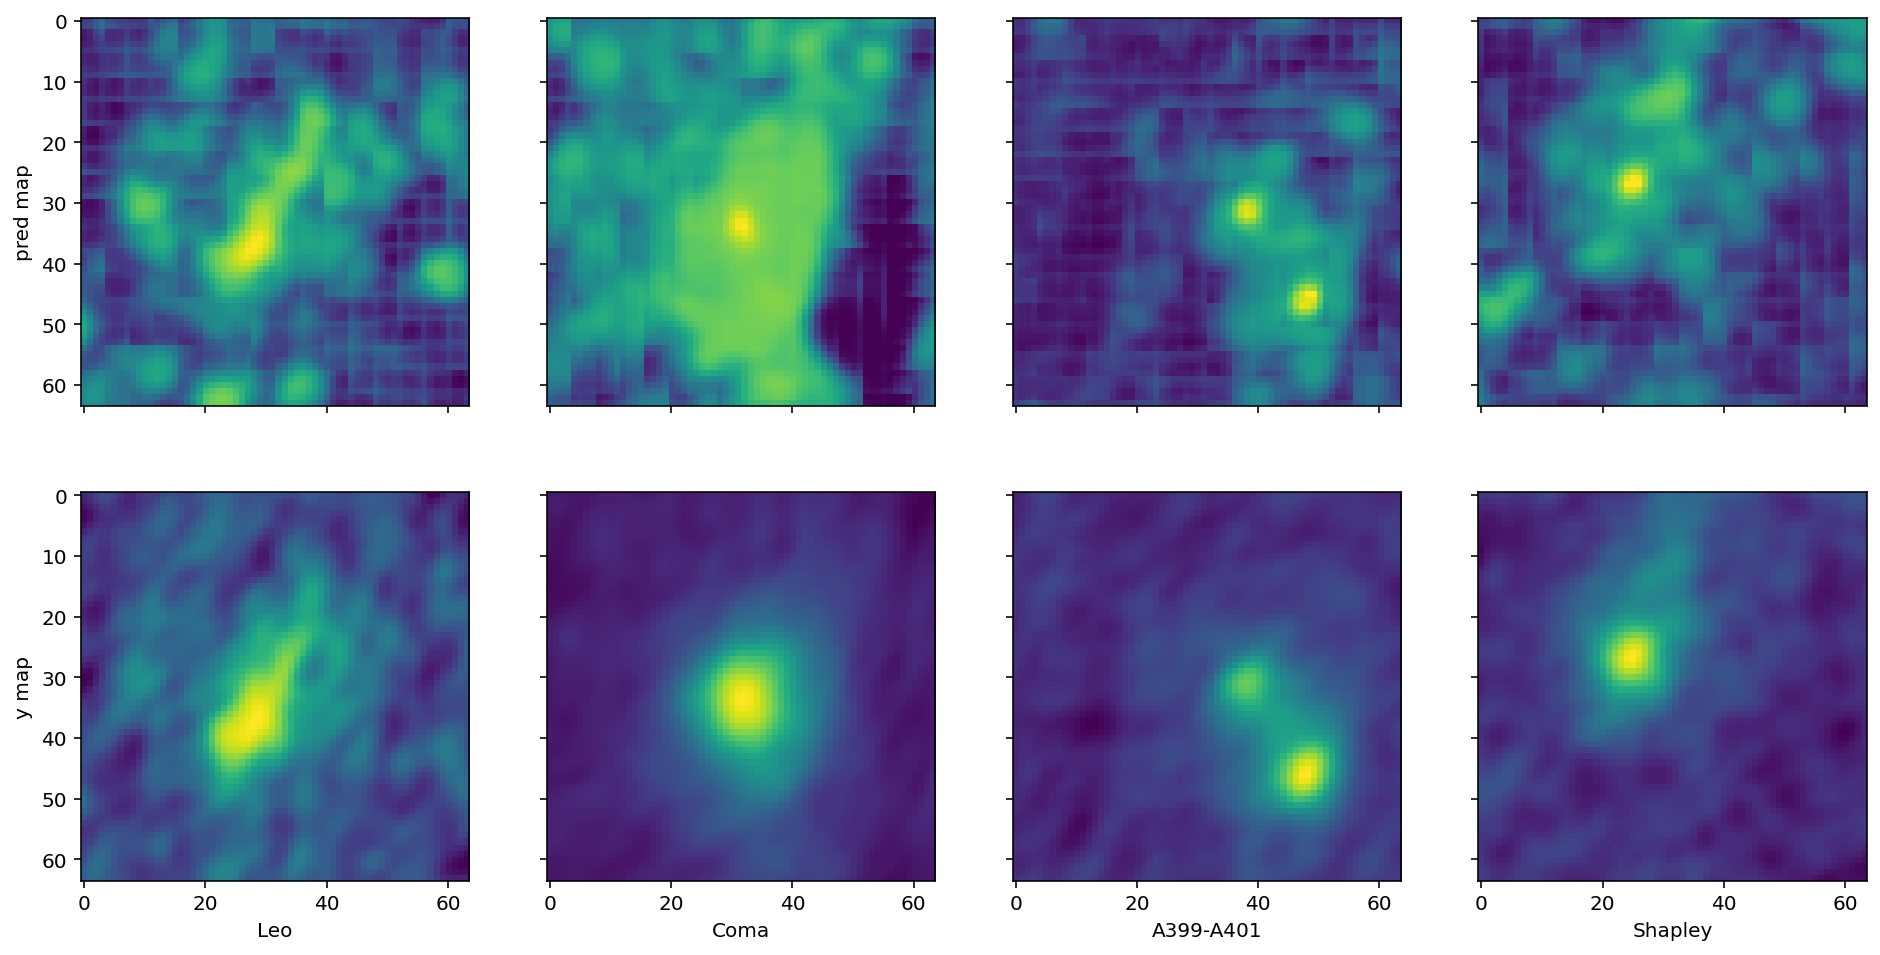

In [58]:
_, ax = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
for i, name in enumerate(pics_dict):
    ax[1][i].set_xlabel(name)
    for j in range(2):
        ax[j][i].imshow(pics_dict[name][j][:,:,0].astype(np.float32))

for j, tname in enumerate(['pred map', 'y map']):
    ax[j][0].set_ylabel(tname)

In [52]:
pics_dict['Coma'][0].shape

(64, 64, 1)